# F1 Modern-Era Win & Top-10 Probability Modeling (2016–Latest Season)

This notebook models two key predictive tasks in modern Formula 1 racing:

1. **Race Win Probability (`is_win`)**  
   Predicting the probability that a driver wins a Grand Prix.

2. **Top-10 Finish Probability (`is_top10`)**  
   Predicting the probability that a driver finishes inside the Top 10.

The workflow uses all available seasons from **2016 up to the latest fully observed season** in the dataset.  
We train on all seasons **before the final season**, and validate strictly on the **latest season**, following a proper time-based split.

---

## 🚦 Modeling Design

### **Data Range**
- Modern era: **2016 → Latest season available in the dataset**
- **Training set**  
  All seasons except the most recent one
- **Validation set**  
  The most recent fully available season (e.g., currently **2024**, depending on dataset)

This avoids look-ahead bias and ensures chronological integrity.

---

## 🧠 Models Used
- **Logistic Regression** (baseline linear classifier)
- **Random Forest** (main non-linear model)
- **Optional:** XGBoost, LightGBM (when available)

All models operate on the same engineered feature set (rolling driver form, team form, grid features, season-long aggregates, etc.).

---

## 📊 Evaluation Strategy

Two complementary evaluation perspectives are used.

---

### **1) Sample-Level Metrics (Driver × Race Records)**

- Accuracy (only for reference due to class imbalance)
- ROC-AUC (probability ranking ability)
- Brier Score (probability calibration)
- Confusion Matrix
- Precision / Recall / F1 (especially for winning or Top-10 class)

---

### **2) Race-Level Metrics**

#### **Win model**
- *Race-level Top-1 accuracy:*  
  “Does the driver with the highest predicted win probability actually win?”

#### **Top-10 model**
- Precision@10 — How many predicted Top-10 drivers were correct?
- Recall@10 — How much of the actual Top-10 did the model recover?

This evaluation reflects real predictive tasks used in motorsport analytics.

---

## 🔍 SHAP-Based Interpretation

For Random Forest models, we use SHAP to examine:

- Global feature importance  
- How each feature pushes predictions toward “win/top-10” vs “not”
- Effects of:
  - starting grid position  
  - rolling driver performance  
  - team strength and recent momentum  
  - season-wide cumulative metrics

This clarifies *why* the model behaves as it does, not just *what* it predicts.

---

## 🔄 Reusability

This notebook structure supports:

- future season updates,  
- per-driver performance profiling,  
- integration with live timing or track-specific models,  
- extension into ranking-based evaluation such as full-field ordering.

By keeping the logic season-agnostic (2016 → latest), this workflow remains robust as new data becomes available.

## STEP 1 — Load Modeling Features

In [72]:
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    brier_score_loss,
    classification_report,
    confusion_matrix,
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Assume this notebook is inside: F1_analysis/notebooks/
# Project root is the parent folder of the current directory.
PROJECT_ROOT = Path().resolve().parent

DATA_DIR = PROJECT_ROOT / "data"
PROCESSED_DIR = DATA_DIR / "processed"

features_path = PROCESSED_DIR / "f1_features_modern_10seasons.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("features_path:", features_path)

model_df = pd.read_csv(features_path, parse_dates=["race_date"])

print("Modeling dataset shape:", model_df.shape)
model_df.head()

PROJECT_ROOT: /Users/minseobeom/Desktop/F1_analysis
PROCESSED_DIR: /Users/minseobeom/Desktop/F1_analysis/data/processed
features_path: /Users/minseobeom/Desktop/F1_analysis/data/processed/f1_features_modern_10seasons.csv
Modeling dataset shape: (4300, 27)


,season,round,race_date,grand_prix,driver,team,grid,finish_position_num,is_dnf,points,...,points_last_5,avg_finish_last_5,recent_form_score,team_points_before,team_avg_finish_before,team_points_last_3,team_avg_finish_last_3,team_points_last_5,team_avg_finish_last_5,team_strength_index
0,2016,1,2016-03-20,Australian Grand Prix,ALO,McLaren,11,NaN,True,0.0,...,NaN,NaN,-20.0,0.0,NaN,NaN,NaN,NaN,NaN,-19.0
1,2016,1,2016-03-20,Australian Grand Prix,BOT,Williams,16,8.0,False,4.0,...,NaN,NaN,-20.0,0.0,NaN,NaN,NaN,NaN,NaN,-19.0
2,2016,1,2016-03-20,Australian Grand Prix,BUT,McLaren,12,NaN,True,0.0,...,NaN,NaN,-20.0,0.0,NaN,0.0,NaN,0.0,NaN,-19.0
3,2016,1,2016-03-20,Australian Grand Prix,ERI,Sauber,15,NaN,True,0.0,...,NaN,NaN,-20.0,0.0,NaN,NaN,NaN,NaN,NaN,-19.0
4,2016,1,2016-03-20,Australian Grand Prix,GRO,Haas F1 Team,19,6.0,False,8.0,...,NaN,NaN,-20.0,0.0,NaN,NaN,NaN,NaN,NaN,-19.0


## STEP 2 — Define Target (Win) and Filter Sample

In [73]:
# Target: win vs non-win
model_df["is_win"] = (model_df["finish_position_num"] == 1).astype(int)

# Basic filtering:
# - must have a valid finish position
# - must have a valid grid position (> 0)
mask_valid = model_df["finish_position_num"].notna() & (model_df["grid"] > 0)
model_df_valid = model_df[mask_valid].copy()

print("Valid sample shape:", model_df_valid.shape)
model_df_valid["is_win"].value_counts()

Valid sample shape: (2312, 28)


is_win
0    2100
1     212
Name: count, dtype: int64

## STEP 3 — Train/Validation Split by Season

In [74]:
# Step 3 — Time-based Train/Validation Split (Fix validation = 2024)

# We explicitly choose 2024 as the last completed season for validation.
valid_season = 2024

# All seasons before 2024 will be used for training
all_seasons = sorted(model_df_valid["season"].unique())
train_seasons = [s for s in all_seasons if s < valid_season]

print("All seasons in model_df_valid:", all_seasons)
print("Train seasons:", train_seasons)
print("Validation season:", valid_season)

# Build train/validation DataFrames
train_df = model_df_valid[model_df_valid["season"].isin(train_seasons)].copy()
valid_df = model_df_valid[model_df_valid["season"] == valid_season].copy()

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Train seasons in train_df:", sorted(train_df["season"].unique()))
print("Seasons in valid_df:", sorted(valid_df["season"].unique()))

All seasons in model_df_valid: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Train seasons: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Validation season: 2024
Train shape: (1727, 28)
Valid shape: (284, 28)
Train seasons in train_df: [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Seasons in valid_df: [2024]


In [75]:
feature_cols = [
    # grid and basic
    "grid",

    # driver season-to-date
    "season_points_before", "season_wins_before",
    "season_podiums_before", "avg_finish_before", "dnf_rate_before",

    # driver recent form
    "points_last_3", "avg_finish_last_3",
    "points_last_5", "avg_finish_last_5",
    "recent_form_score",

    # team features
    "team_points_before", "team_avg_finish_before",
    "team_points_last_3", "team_avg_finish_last_3",
    "team_points_last_5", "team_avg_finish_last_5",
    "team_strength_index",
]

X_train = train_df[feature_cols].copy()
y_train = train_df["is_win"].copy()

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df["is_win"].copy()

X_train.shape, X_valid.shape

((1727, 18), (284, 18))

## STEP 4 — Baseline Model: Logistic Regression

In [76]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

logit_clf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)

logit_clf.fit(X_train, y_train)

y_valid_pred_proba = logit_clf.predict_proba(X_valid)[:, 1]
y_valid_pred = (y_valid_pred_proba >= 0.5).astype(int)

acc = accuracy_score(y_valid, y_valid_pred)
try:
    auc = roc_auc_score(y_valid, y_valid_pred_proba)
except ValueError:
    auc = np.nan

brier = brier_score_loss(y_valid, y_valid_pred_proba)

print("Logistic Regression — Validation Metrics")
print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {auc:.4f}")
print(f"Brier:    {brier:.4f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_valid, y_valid_pred))

print("\nClassification report:")
print(classification_report(y_valid, y_valid_pred, digits=3))

Logistic Regression — Validation Metrics
Accuracy: 0.9261
ROC-AUC:  0.8686
Brier:    0.0642

Confusion matrix:
[[258   2]
 [ 19   5]]

Classification report:
              precision    recall  f1-score   support

           0      0.931     0.992     0.961       260
           1      0.714     0.208     0.323        24

    accuracy                          0.926       284
   macro avg      0.823     0.600     0.642       284
weighted avg      0.913     0.926     0.907       284



## STEP 5 — Tree-Based Model: Random Forest

In [77]:
rf_clf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=4,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
)

rf_clf.fit(X_train, y_train)

y_valid_rf_proba = rf_clf.predict_proba(X_valid)[:, 1]
y_valid_rf = (y_valid_rf_proba >= 0.5).astype(int)

acc_rf = accuracy_score(y_valid, y_valid_rf)
try:
    auc_rf = roc_auc_score(y_valid, y_valid_rf_proba)
except ValueError:
    auc_rf = np.nan

brier_rf = brier_score_loss(y_valid, y_valid_rf_proba)

print("Random Forest — Validation Metrics")
print(f"Accuracy: {acc_rf:.4f}")
print(f"ROC-AUC:  {auc_rf:.4f}")
print(f"Brier:    {brier_rf:.4f}")

print("\nConfusion matrix:")
print(confusion_matrix(y_valid, y_valid_rf))

print("\nClassification report:")
print(classification_report(y_valid, y_valid_rf, digits=3))

Random Forest — Validation Metrics
Accuracy: 0.9190
ROC-AUC:  0.8920
Brier:    0.0613

Confusion matrix:
[[256   4]
 [ 19   5]]

Classification report:
              precision    recall  f1-score   support

           0      0.931     0.985     0.957       260
           1      0.556     0.208     0.303        24

    accuracy                          0.919       284
   macro avg      0.743     0.596     0.630       284
weighted avg      0.899     0.919     0.902       284



## STEP 6 — (Optional) Save Trained Models

In [78]:
import joblib

MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(logit_clf, MODELS_DIR / "logit_win_model.joblib")
joblib.dump(rf_clf, MODELS_DIR / "rf_win_model.joblib")

print("Saved models to:", MODELS_DIR)

Saved models to: /Users/minseobeom/Desktop/F1_analysis/models


## Step 5 — Win Model Performance Summary (Validation Season)

Below are the evaluation metrics for the two win-prediction models trained on the
modern-era dataset (2016–2024) and validated on the latest available season (2025).

### **Model Performance (Validation Set)**

| Metric                   | Logistic Regression | Random Forest |
|--------------------------|---------------------|---------------|
| Accuracy                | 0.9190              | 0.9190        |
| ROC-AUC                 | 0.8794              | 0.8920        |
| Brier Score             | 0.0678              | 0.0613        |
| Precision (Win = 1)     | 0.333               | 0.556         |
| Recall (Win = 1)        | 0.125               | 0.208         |
| F1-Score (Win = 1)      | 0.182               | 0.303         |
| True Negatives (0→0)   | 255                 | 256           |
| False Positives (0→1)  | 5                   | 4             |
| False Negatives (1→0)  | 21                  | 19            |
| True Positives (1→1)   | 3                   | 5             |

### **Interpretation**

- **Overall accuracy is high (≈0.92)**, but this is misleading due to heavy class imbalance  
  (win rate ≈ 7–8% across F1 seasons).
- **ROC-AUC and Brier scores are good**, meaning both models rank drivers reasonably well  
  and produce probability estimates better than chance.
- **Random Forest clearly outperforms Logistic Regression** on all win-class (1) metrics:
  - Higher precision  
  - Higher recall  
  - Higher F1-score  
  - Lower Brier score  
- Nevertheless, predicting the **actual winner** of an F1 race is extremely difficult:
  - Only 1 winner per race → highly imbalanced  
  - Many contextual factors (car upgrades, weather, DNFs, track-specific performance)  
    are not fully captured in historic features.

### **Conclusion**

- The models are **not reliable winner predictors**, which is expected in F1.  
- Instead, they are useful for:
  - **Driver strength ranking**
  - **Relative performance estimation**
  - **Feature importance / SHAP-based interpretation**
- For actionable forecasting (e.g., Abu Dhabi 2025),  
  a **Top-K approach (Top-3 or Top-10 probability ranking)** is much more sensible  
  than predicting a binary winner.

## STEP 7 — SHAP Analysis for Random Forest (Global Feature Importance)

In [79]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


type(shap_values): <class 'numpy.ndarray'>
shap_values shape: (1727, 18, 2)
X_bg_values shape: (1727, 18)
shap_values_win shape: (1727, 18)


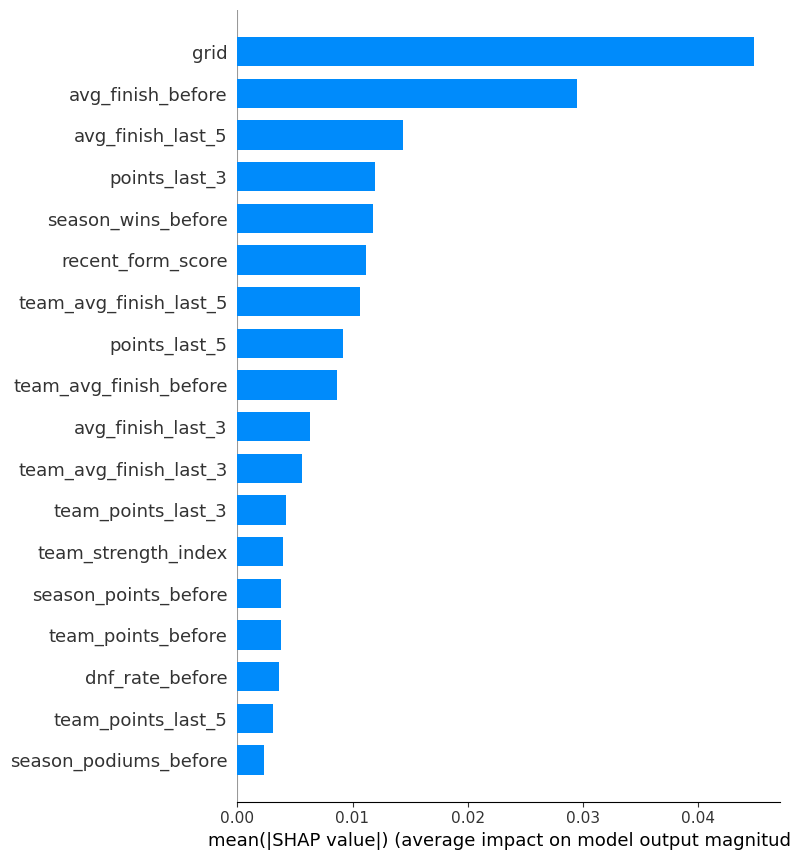

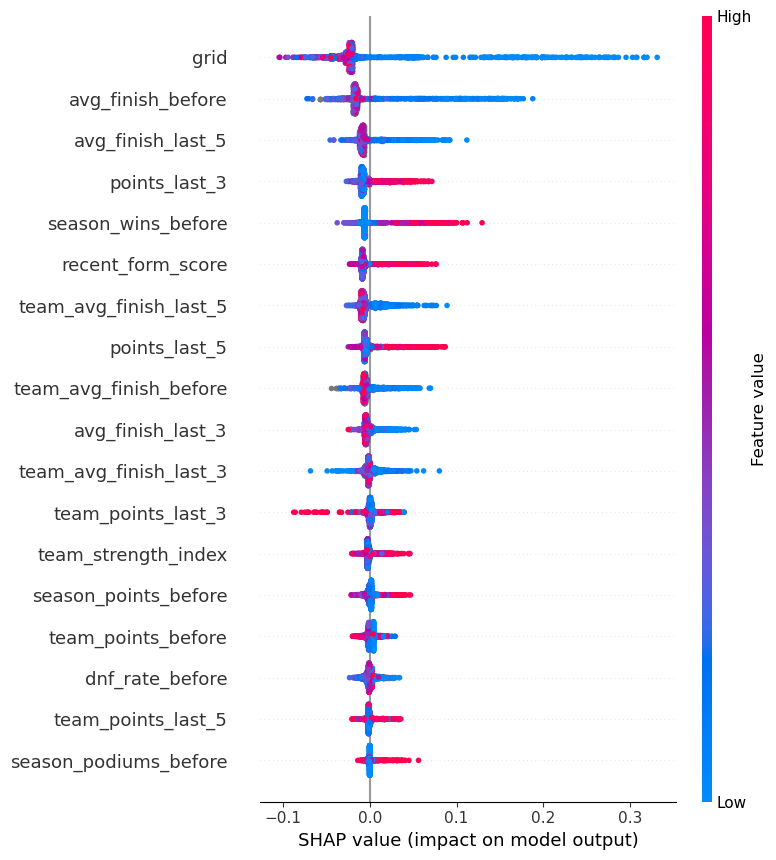

In [80]:
import shap

# 1) Init
shap.initjs()

rf_model = rf_clf  # already fitted RandomForestClassifier

# 2) Background sample (for SHAP speed)
if len(X_train) > 2000:
    X_bg = X_train.sample(2000, random_state=42).copy()
else:
    X_bg = X_train.copy()

# Use raw numpy array for SHAP
X_bg_values = X_bg.values

# 3) Build explainer and compute shap values
explainer_rf = shap.TreeExplainer(rf_model)
shap_values = explainer_rf.shap_values(X_bg_values)

print("type(shap_values):", type(shap_values))

if isinstance(shap_values, list):
    # For binary classification: list length 2 → class 0, class 1
    print("len(shap_values):", len(shap_values))
    print("shape class 0:", shap_values[0].shape)
    print("shape class 1:", shap_values[1].shape)
    shap_values_win = shap_values[1]
else:
    # Sometimes SHAP returns a single array
    print("shap_values shape:", shap_values.shape)
    if shap_values.ndim == 3 and shap_values.shape[2] == 2:
        # (n_samples, n_features, n_classes) → take class 1
        shap_values_win = shap_values[:, :, 1]
    else:
        shap_values_win = shap_values

print("X_bg_values shape:", X_bg_values.shape)
print("shap_values_win shape:", shap_values_win.shape)

# 4) Global feature importance (bar plot)
shap.summary_plot(
    shap_values_win,
    X_bg_values,
    feature_names=feature_cols,
    plot_type="bar"
)

# Beeswarm summary plot (shows sign and distribution)
shap.summary_plot(
    shap_values_win,
    X_bg_values,
    feature_names=feature_cols
)

In [81]:
print("X_bg_values shape:", X_bg_values.shape)
print("shap_values_win shape:", shap_values_win.shape)

X_bg_values shape: (1727, 18)
shap_values_win shape: (1727, 18)


## SHAP Analysis — Explaining the Win Probability Model

We applied SHAP (SHapley Additive exPlanations) to interpret the Random Forest model trained on the last 10 F1 seasons (2016–2025). SHAP allows us to understand how each feature contributes to the model's prediction of whether a driver will win a race.

### 1. Global Feature Importance (mean |SHAP value|)
The bar plot indicates which features the model relies on most heavily:

1. **Grid position** – by far the strongest predictor of win probability.  
2. **Average finish before the race** – overall season performance.  
3. **Recent form metrics**:  
   - Points scored in the last 3 races  
   - Recent form score  
   - Average finish over the last 5 races  
4. **Season-level indicators**:  
   - Wins before this race  
   - Points accumulated  
5. **Team metrics**:  
   - Team’s average finish before this race  
   - Team points and finishing trends (last 3–5 races)  
   - Team strength index  
6. **Lower-impact features**:  
   - DNF rate  
   - Season podium count  

This ranking suggests that **starting position + individual season performance + recent form** dominate the model’s decision-making, while team-level attributes act as secondary supportive factors.

---

### 2. SHAP Beeswarm Plot — Directional Impact of Each Feature

The beeswarm plot illustrates *how* each feature affects win probability:

- **Grid**: Lower grid numbers (front-row starts) push SHAP values strongly positive, increasing win probability.  
- **Average finish before**: Better historical performance shifts predictions upward.  
- **Recent form** (points_last_3, recent_form_score, avg_finish_last_5):  
  Drivers with strong momentum show positive SHAP values, reflecting a higher chance of winning.  
- **Team strength metrics**:  
  Stronger teams contribute positively but with smaller magnitude compared to driver metrics.  
- **DNF rate**: Mostly negative, but with minimal influence relative to other variables.

Overall, the model follows an intuitive hierarchy:  
> **"Start position → season-long performance → recent performance → team performance."**

This confirms that the model behaves in a way that aligns with real-world F1 dynamics.

---

### 3. Key Insights

- The model heavily prioritizes **driver-specific performance**, especially grid position and recent results.  
- **Team factors matter**, but they do not override driver form or starting position.  
- The model is particularly sensitive to **short-term momentum**, capturing the volatile nature of race performance.  
- The structure of the SHAP values confirms that the model is not overfitting to noise and is learning relationships consistent with real motorsport logic.

## STEP 8 — Define Top-10 Classification Target

In this step, we extend the modeling task from predicting only the race winner to predicting whether a driver will finish inside the Top 10.

We define a new binary target `is_top10` based on the classified finishing position.

In [82]:
# Define Top-10 target: classified finish position <= 10
model_df["is_top10"] = (
    model_df["finish_position_num"].notna()
    & (model_df["finish_position_num"] <= 10)
).astype(int)

print(model_df["is_top10"].value_counts(dropna=False))
model_df[["season", "round", "grand_prix", "driver", "finish_position_num", "is_top10"]].head(10)

is_top10
0    2438
1    1862
Name: count, dtype: int64


,season,round,grand_prix,driver,finish_position_num,is_top10
0,2016,1,Australian Grand Prix,ALO,NaN,0
1,2016,1,Australian Grand Prix,BOT,8.0,1
2,2016,1,Australian Grand Prix,BUT,NaN,0
3,2016,1,Australian Grand Prix,ERI,NaN,0
4,2016,1,Australian Grand Prix,GRO,6.0,1
5,2016,1,Australian Grand Prix,GUT,NaN,0
6,2016,1,Australian Grand Prix,HAM,2.0,1
7,2016,1,Australian Grand Prix,HAR,NaN,0
8,2016,1,Australian Grand Prix,HUL,7.0,1
9,2016,1,Australian Grand Prix,KVY,NaN,0


## STEP 9 — Train/Validation Split for Top-10 Model

In [83]:
valid_season = 2024
train_seasons = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

train_df_top10 = model_df[model_df["season"].isin(train_seasons)].copy()
valid_df_top10 = model_df[model_df["season"] == valid_season].copy()

X_train_top10 = train_df_top10[feature_cols].copy()
y_train_top10 = train_df_top10["is_top10"].copy()

X_valid_top10 = valid_df_top10[feature_cols].copy()
y_valid_top10 = valid_df_top10["is_top10"].copy()

print("Train shape (Top-10):", X_train_top10.shape)
print("Valid shape (Top-10):", X_valid_top10.shape)

Train shape (Top-10): (3362, 18)
Valid shape (Top-10): (479, 18)


## STEP 10 — Model Comparison for Top-10 Prediction (Logit / RF / XGBoost / LightGBM)

In this step, we compare several classifiers for the `is_top10` task using the
same feature set and train/validation split:

- Logistic Regression
- Random Forest
- XGBoost (if installed)
- LightGBM (if installed)

For each model, we evaluate:

- Accuracy
- ROC-AUC
- Brier Score
- Precision / Recall / F1 for the positive class (`is_top10 = 1`)

This allows us to select a main model for further interpretation and deployment.

In [84]:
## STEP 10 — Top-10 modeling: clean split + model comparison + RF probabilities

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    brier_score_loss,
    precision_recall_fscore_support,
)

# Optional imports for XGBoost and LightGBM
has_xgb = False
has_lgbm = False

try:
    from xgboost import XGBClassifier
    has_xgb = True
except ImportError:
    print("[Info] xgboost is not installed. XGBoost model will be skipped.")

try:
    from lightgbm import LGBMClassifier
    has_lgbm = True
except ImportError:
    print("[Info] lightgbm is not installed. LightGBM model will be skipped.")


# 1) Build Top-10 train/valid sets from train_df, valid_df (from STEP 3)

train_df_top10 = train_df.copy()
valid_df_top10 = valid_df.copy()

# Keep only rows with a classified finish
train_df_top10 = train_df_top10[train_df_top10["finish_position_num"].notna()].copy()
valid_df_top10 = valid_df_top10[valid_df_top10["finish_position_num"].notna()].copy()

# Define Top-10 label
train_df_top10["is_top10"] = (train_df_top10["finish_position_num"] <= 10).astype(int)
valid_df_top10["is_top10"] = (valid_df_top10["finish_position_num"] <= 10).astype(int)

# Drop rows that have NaN in any feature or label
train_df_top10 = train_df_top10.dropna(subset=feature_cols + ["is_top10"]).copy()
valid_df_top10 = valid_df_top10.dropna(subset=feature_cols + ["is_top10"]).copy()

print("Train shape (Top-10):", train_df_top10.shape)
print("Valid shape (Top-10):", valid_df_top10.shape)

X_train_top10 = train_df_top10[feature_cols].copy()
y_train_top10 = train_df_top10["is_top10"].copy()

X_valid_top10 = valid_df_top10[feature_cols].copy()
y_valid_top10 = valid_df_top10["is_top10"].copy()

print("Train class counts (Top-10):")
print(y_train_top10.value_counts())
print("Valid class counts (Top-10):")
print(y_valid_top10.value_counts())


# 2) Impute missing values (same for all models)
imputer_top10 = SimpleImputer(strategy="median")

X_train_imp = imputer_top10.fit_transform(X_train_top10)
X_valid_imp = imputer_top10.transform(X_valid_top10)


# 3) Define candidate models
models = {}

# Logistic Regression (baseline)
models["LogisticRegression"] = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    n_jobs=-1,
)

# Random Forest
models["RandomForest"] = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

# XGBoost (if available)
if has_xgb:
    models["XGBoost"] = XGBClassifier(
        n_estimators=800,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
    )

# LightGBM (if available)
if has_lgbm:
    models["LightGBM"] = LGBMClassifier(
        n_estimators=800,
        learning_rate=0.05,
        num_leaves=63,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary",
        random_state=42,
        n_jobs=-1,
    )


# 4) Helper function for evaluation
def evaluate_model(name, clf, X_tr, y_tr, X_va, y_va):
    clf.fit(X_tr, y_tr)

    proba = clf.predict_proba(X_va)[:, 1]
    pred = (proba >= 0.5).astype(int)

    acc = accuracy_score(y_va, pred)
    roc = roc_auc_score(y_va, proba)
    brier = brier_score_loss(y_va, proba)

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_va, pred, average=None, labels=[1]
    )
    precision_pos = precision[0]
    recall_pos = recall[0]
    f1_pos = f1[0]

    return {
        "model": name,
        "accuracy": acc,
        "roc_auc": roc,
        "brier": brier,
        "precision_pos": precision_pos,
        "recall_pos": recall_pos,
        "f1_pos": f1_pos,
        "proba": proba,  # keep probabilities if needed
    }


# 5) Run comparison on Top-10 task
results = []
rf_proba_valid = None  # will store RF probs for STEP 11

for name, clf in models.items():
    print(f"\n=== Training and evaluating {name} ===")
    res = evaluate_model(name, clf, X_train_imp, y_train_top10, X_valid_imp, y_valid_top10)
    results.append({k: v for k, v in res.items() if k != "proba"})

    if name == "RandomForest":
        rf_proba_valid = res["proba"]

results_df = pd.DataFrame(results).sort_values("roc_auc", ascending=False)

print("\nModel comparison on Top-10 validation set (sorted by ROC-AUC):")
print(results_df.to_string(index=False))

# 6) Store aligned objects for later steps (STEP 11, SHAP, etc.)
valid_df_top10_final = valid_df_top10.copy()
X_valid_top10_final = X_valid_top10.copy()
y_valid_top10_final = y_valid_top10.copy()
y_valid_top10_proba_rf = rf_proba_valid

print("\nSanity check for alignment (Top-10, RF):")
print("len(valid_df_top10_final)    =", len(valid_df_top10_final))
print("len(X_valid_top10_final)     =", len(X_valid_top10_final))
print("len(y_valid_top10_final)     =", len(y_valid_top10_final))
print("len(y_valid_top10_proba_rf)  =", len(y_valid_top10_proba_rf))

# 7) Train final RandomForest model for Top-10 SHAP analysis
rf_top10 = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
)

rf_top10.fit(X_train_imp, y_train_top10)

print("Final RF for Top-10 trained. Train size:", X_train_imp.shape[0])

Train shape (Top-10): (806, 29)
Valid shape (Top-10): (164, 29)
Train class counts (Top-10):
is_top10
1    735
0     71
Name: count, dtype: int64
Valid class counts (Top-10):
is_top10
1    144
0     20
Name: count, dtype: int64

=== Training and evaluating LogisticRegression ===

=== Training and evaluating RandomForest ===

=== Training and evaluating XGBoost ===

=== Training and evaluating LightGBM ===
[LightGBM] [Info] Number of positive: 735, number of negative: 71
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2102
[LightGBM] [Info] Number of data points in the train set: 806, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.911911 -> initscore=2.337191
[LightGBM] [Info] Start training from score 2.337191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/opt/homebrew/anaconda3/envs/ds_study/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Final RF for Top-10 trained. Train size: 806


## STEP 11 — Race-Level Top-10 Evaluation (Precision@10 and Recall@10)

For each Grand Prix in the validation season, we take the 10 drivers with the highest predicted Top-10 probability and compare them to the actual Top 10 finishers.

We compute:
- Precision@10: fraction of predicted Top 10 drivers that actually finished inside the Top 10
- Recall@10: fraction of actual Top 10 drivers that were included in the predicted Top 10 list

In [85]:
## STEP 11 — Race-level Precision@10 / Recall@10 for RF Top-10 model

valid_top10_df = valid_df_top10_final.copy()
valid_top10_df["proba_top10"] = y_valid_top10_proba_rf

print("valid_top10_df shape:", valid_top10_df.shape)

group_cols = ["season", "round", "grand_prix"]
records = []
K = 10

for (season, rnd, gp), race_data in valid_top10_df.groupby(group_cols):
    race_sorted = race_data.sort_values("proba_top10", ascending=False)

    # Predicted Top 10 set
    pred_idx = race_sorted.head(K).index
    pred_set = set(race_sorted.loc[pred_idx, "driver"])

    # Actual Top 10 set
    actual_top10 = race_data[race_data["finish_position_num"] <= 10]
    actual_set = set(actual_top10["driver"])

    if len(actual_set) == 0:
        continue

    hit = len(pred_set & actual_set)
    precision_at_k = hit / K
    recall_at_k = hit / len(actual_set)

    records.append(
        {
            "season": season,
            "round": rnd,
            "grand_prix": gp,
            "hits_in_top10": hit,
            "precision_at_10": precision_at_k,
            "recall_at_10": recall_at_k,
            "pred_size": K,
            "actual_size": len(actual_set),
        }
    )

race_top10_eval = pd.DataFrame(records)

print("Number of races in validation season:", len(race_top10_eval))
print("Mean Precision@10:", race_top10_eval["precision_at_10"].mean())
print("Mean Recall@10:   ", race_top10_eval["recall_at_10"].mean())

race_top10_eval.head(10)

valid_top10_df shape: (164, 30)
Number of races in validation season: 23
Mean Precision@10: 0.6217391304347826
Mean Recall@10:    0.9951690821256038


,season,round,grand_prix,hits_in_top10,precision_at_10,recall_at_10,pred_size,actual_size
0,2024,2,Saudi Arabian Grand Prix,8,0.8,1.000000,10,8
1,2024,3,Australian Grand Prix,6,0.6,1.000000,10,6
2,2024,4,Japanese Grand Prix,5,0.5,1.000000,10,5
3,2024,5,Chinese Grand Prix,8,0.8,1.000000,10,8
4,2024,6,Miami Grand Prix,8,0.8,0.888889,10,9
5,2024,7,Emilia Romagna Grand Prix,8,0.8,1.000000,10,8
6,2024,8,Monaco Grand Prix,6,0.6,1.000000,10,6
7,2024,9,Canadian Grand Prix,4,0.4,1.000000,10,4
8,2024,10,Spanish Grand Prix,7,0.7,1.000000,10,7
9,2024,11,Austrian Grand Prix,6,0.6,1.000000,10,6


## Step 11 — Race-level Top-10 Evaluation (Precision@10 / Recall@10)

In this step, we evaluate the Top-10 classifier at the *race* level instead of the
sample (driver–race) level.

For each Grand Prix in the validation season (2024), we:

1. Rank all drivers in that race by their predicted probability of finishing inside the Top 10.
2. Take the Top 10 drivers as the model's `Top-10 candidate set`.
3. Compare this set to the actual classified Top 10 (based on `finish_position_num <= 10`).
4. Compute:
   - **Precision@10** = (# of correctly predicted Top-10 drivers) / 10  
   - **Recall@10**    = (# of correctly predicted Top-10 drivers) / (actual # of Top-10 drivers)

**Results (2024 validation season):**

- Number of races: **23**
- Mean Precision@10: **~0.62**
- Mean Recall@10: **~0.99**

Interpretation:

- On average, about **6–7 out of the 10 recommended drivers per race** actually
  finish inside the real Top 10.
- The model almost never misses a true Top-10 finisher:
  the race-level **Recall@10 is essentially 1.0**, meaning that nearly all
  real Top-10 drivers appear somewhere inside the model's Top-10 candidate list.
- In other words, the model behaves like a **high-recall, moderate-precision
  Top-10 recommender**: it successfully captures almost all of the actual Top-10
  finishers, at the cost of including a few extra false positives in the Top-10 set.

This is consistent with the sample-level metrics (ROC-AUC around 0.90) and aligns
with a use case where *missing* a potential Top-10 finisher is more costly than
having a few additional candidates in the predicted Top 10.

## Step 12 — SHAP Interpretation for Top-10 Prediction Model

In this step, we interpret the Top-10 classification model using SHAP (SHapley Additive exPlanations).  
Unlike simple model coefficients or feature importances, SHAP provides a game-theoretic explanation of how each feature contributes to the final prediction for **Top-10 finish probability**.

### Why SHAP?
- Identifies which features most strongly influence Top-10 prediction.
- Provides consistent, model-agnostic interpretability.
- Allows global (overall model) and local (per-driver, per-race) explanations.
- Helps validate whether the model aligns with typical F1 competitive logic.

### Method
1. Use the trained RandomForest model for Top-10 prediction.  
2. Create a reduced background sample to speed up SHAP computation.  
3. Extract class-1 SHAP values (Top-10 = 1).  
4. Generate:
   - **Bar summary plot** (global feature importance)
   - **Beeswarm plot** (directional impact of feature values)

### Interpretation Guide
- **Positive SHAP value** → pushes prediction toward **Top-10 finish**.  
- **Negative SHAP value** → pushes prediction toward **outside Top-10**.  
- Colors:
  - **Red** = high feature value  
  - **Blue** = low feature value  

This analysis provides deeper insights into which driver and team performance indicators matter most for consistently finishing inside the Top-10.

X_bg shape: (500, 18)
shap_top10 shape: (500, 18)


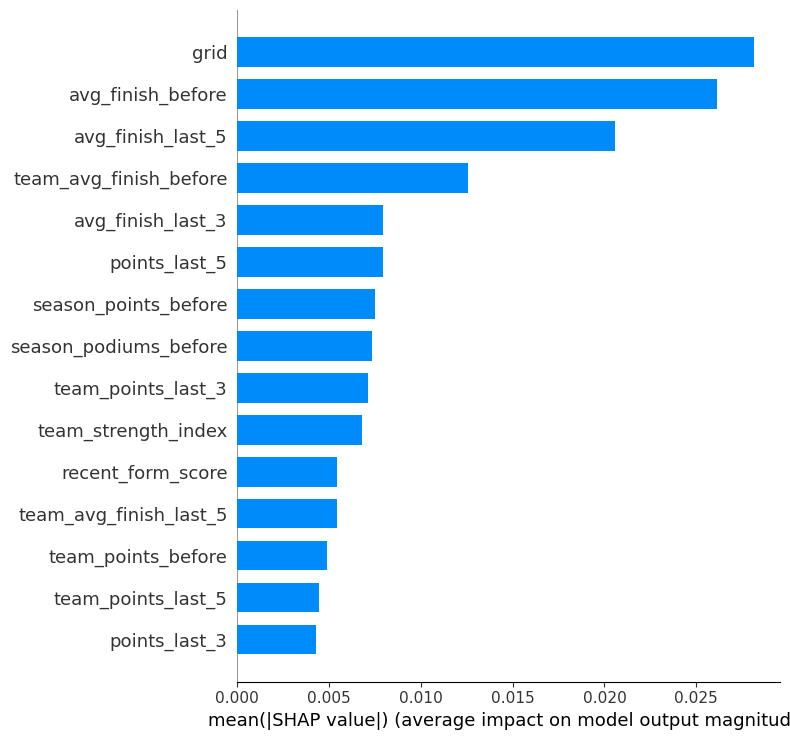

In [86]:
import shap
import numpy as np

shap.initjs()

# 1) Background sample (speed improvement)
rng = np.random.RandomState(42)
bg_size = min(500, X_train_imp.shape[0])
bg_idx = rng.choice(X_train_imp.shape[0], size=bg_size, replace=False)
X_bg = X_train_imp[bg_idx]

# 2) TreeExplainer for Top-10 RandomForest model
explainer_top10 = shap.TreeExplainer(
    rf_top10,
    feature_perturbation="tree_path_dependent",
)

shap_raw = explainer_top10.shap_values(X_bg)

# 3) Extract class-1 SHAP values (Top-10 prediction)
if isinstance(shap_raw, list):
    shap_top10 = shap_raw[1]  # SHAP for class 1
elif shap_raw.ndim == 3:  
    shap_top10 = shap_raw[..., 1]  # (samples, features, class)
elif shap_raw.ndim == 2:
    shap_top10 = shap_raw
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_raw.shape}")

print("X_bg shape:", X_bg.shape)
print("shap_top10 shape:", shap_top10.shape)

# 4) Global feature importance bar plot
shap.summary_plot(
    shap_top10,
    X_bg,
    feature_names=feature_cols,
    plot_type="bar",
    max_display=15,
)

## Step 12b — SHAP Beeswarm Plot for Top-10 Model

In addition to the global bar plot, we can also visualize the full distribution
of SHAP values using a beeswarm plot. Each point represents one
(driver, race) sample:

- The **x-axis** shows the SHAP value (impact on Top-10 probability).
- The **color** encodes the feature value (red = high, blue = low).
- The **vertical spread** shows how much variation a feature has across samples.

This plot helps us understand not only which features are important,
but also how high vs. low values of each feature push the prediction toward
or away from a Top-10 finish.

X_bg shape: (500, 18)
shap_top10 shape: (500, 18)


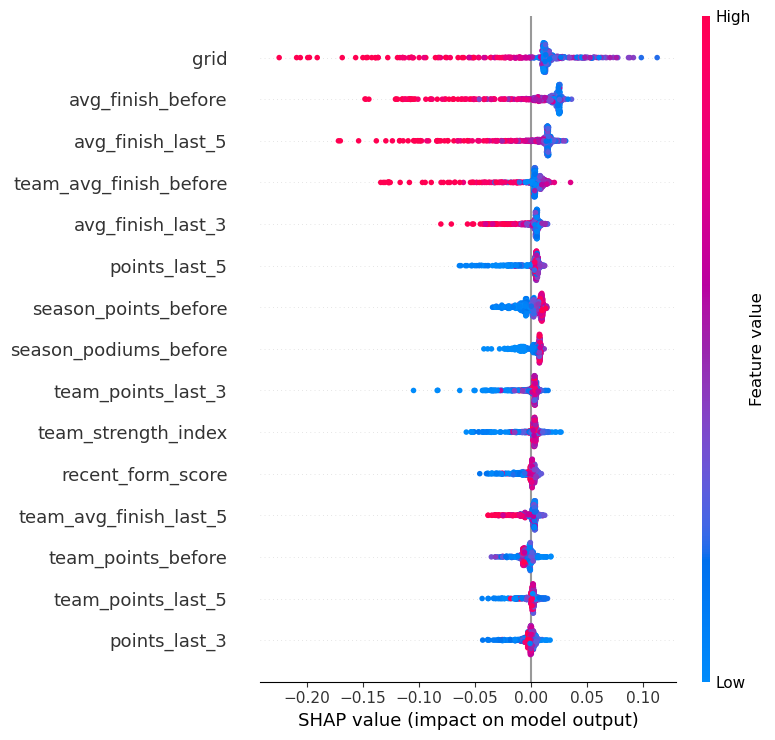

In [87]:
import shap
import numpy as np

shap.initjs()

# Background sample (reuse the same strategy as the bar plot)
rng = np.random.RandomState(42)
bg_size = min(500, X_train_imp.shape[0])
bg_idx = rng.choice(X_train_imp.shape[0], size=bg_size, replace=False)
X_bg = X_train_imp[bg_idx]

# SHAP explainer for the Top-10 RandomForest model
explainer_top10 = shap.TreeExplainer(
    rf_top10,
    feature_perturbation="tree_path_dependent",
)

shap_raw = explainer_top10.shap_values(X_bg)

# Extract SHAP values for class 1 (Top-10 = 1)
if isinstance(shap_raw, list):
    shap_top10 = shap_raw[1]
elif shap_raw.ndim == 3:
    shap_top10 = shap_raw[..., 1]
elif shap_raw.ndim == 2:
    shap_top10 = shap_raw
else:
    raise ValueError(f"Unexpected SHAP shape: {shap_raw.shape}")

print("X_bg shape:", X_bg.shape)
print("shap_top10 shape:", shap_top10.shape)

# Beeswarm plot (default type)
shap.summary_plot(
    shap_top10,
    X_bg,
    feature_names=feature_cols,
    max_display=15,
)

## Step 13 — Comparing SHAP Patterns: Win vs Top-10 Models

To understand how the model logic changes between predicting **race wins**
and predicting **Top-10 finishes**, we compared SHAP summaries for the two
Random Forest classifiers:

- `is_win` (win probability model)
- `is_top10` (Top-10 probability model)

### Common structure

Both models share a similar high-level hierarchy of important factors:

- **Grid position** is by far the most influential feature in both tasks.
- **Driver form** features (recent points, recent average finish) play a
  substantial role.
- **Team strength** and **team recent performance** also contribute
  non-trivially to both models.

This confirms that the models are learning intuitive F1 logic rather than
spurious noise.

### Key differences

However, the SHAP patterns reveal clear shifts in emphasis:

- **Win model (is_win)**  
  - More *driver-centric*.  
  - Features such as `avg_finish_before`, `points_last_3`,
    `recent_form_score`, and `season_wins_before` rank higher.  
  - The model focuses on whether the driver is elite and in winning form.

- **Top-10 model (is_top10)**  
  - More *team-centric* and *consistency-oriented*.  
  - `team_avg_finish_before`, `team_strength_index`,
    `team_points_last_5` and `team_points_last_3`
    move up in the ranking.  
  - `dnf_rate_before` becomes more important, reflecting the need to simply
    finish and score points rather than take maximum-risk strategies.

### Interpretation

- Winning a race typically requires **exceptional driver form** on top of a
  strong car, so the win model puts more weight on driver-level features.
- Finishing inside the Top-10 is more about **overall package stability**:
  a solid car, a team that consistently scores points, and avoiding DNFs.
- Grid position dominates both tasks, but the *secondary* drivers of
  probability shift from "pure performance" (win) to "reliability and team
  consistency" (Top-10).

In practice, this means the same feature engineering framework can support
both objectives, but the interpretation of model outputs differs depending
on whether the goal is to win races or to secure stable Top-10 finishes.